In [16]:
pip install shap

In [17]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

In [18]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("CUDA is not availible. Using CPU instead.")

Using GPU: Tesla T4


### Data Cleaning and Preprocessing
### Steps:
1. Drop any row with missing/unknown values. This reduces size of dataset from 106 M to 700 K.
2. Get rid of all columns related to date/time.
3. One-hot encode all categorical variables and keep only one of any column with binary outcome after one-hot encoding.

In [19]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")

In [20]:
for col in df.columns:
    print(col)

cdc_case_earliest_dt
cdc_report_dt
current_status
sex
age_group
race_ethnicity_combined
hosp_yn
icu_yn
death_yn
medcond_yn
pos_spec_dt
onset_dt


In [21]:
def one_hot_encoding_features(df, columns_to_encode):
  for column in columns_to_encode:
    if column not in df.columns:
      raise ValueError(f"Column '{column}' not found in DataFrame.")
  df_encoded = pd.get_dummies(df, columns=columns_to_encode)

  return df_encoded

Based on our previous model in the RF 1 notebook, we see that hospitalization status and ICU admission primarily drive the model, and we also have the issue of a data imbalance. We will try re-evaluating the model to consider hospitalization and ICU status as features and reduce the severe amount of non-death cases we have.

We will try:
1. Compute and evaluate a model without hospitalization status and perform feature analysis
2. Compute and evaluate a model without ICU admission status and perform feature analysis
3. Compute and evaluate a model without hospitalization & ICU admission status and perform feature analysis
4. Compute and evaluate a model without hospitalization & ICU admission status and perform feature analysis with balanced target values, with equal amount of death and non-death cases.

Overall, we see that removing features like hospitalization status and ICU admission status decrease the accuracy and AUC of our model, and especially cause a sharp decrease in PR values and our PR-AUC--the removal of the features combined with the data imbalance not helping matters. As far as feature analysis, we see that pre-existing conditions and old age are the features that drive our model when hosptialization and ICU is not present.

When the data is balanced, we see our precision and recall values increase, doing a very good job at minimizing false positives for death prediction and capturing actual death cases. PR-AUC goes up to 0.86, a sharp improvement. The PR values maximize when optimzing hyperparameters as well.

### 1. Dropping 'hosp_yn_Yes'

In [22]:
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [23]:
df.head()

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic","race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [24]:
for col in df.columns:
    print(col)

current_status_Laboratory-confirmed case
current_status_Probable Case
sex_Female
sex_Male
sex_Other
age_group_0 - 9 Years
age_group_10 - 19 Years
age_group_20 - 29 Years
age_group_30 - 39 Years
age_group_40 - 49 Years
age_group_50 - 59 Years
age_group_60 - 69 Years
age_group_70 - 79 Years
age_group_80+ Years
race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic
race_ethnicity_combined_Asian, Non-Hispanic
race_ethnicity_combined_Black, Non-Hispanic
race_ethnicity_combined_Hispanic/Latino
race_ethnicity_combined_Multiple/Other, Non-Hispanic
race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic
race_ethnicity_combined_White, Non-Hispanic
icu_yn_Yes
death_yn_Yes
medcond_yn_Yes


death_yn_Yes
False    701401
True      28786
Name: count, dtype: int64
death_yn_Yes
False    0.960577
True     0.039423
Name: count, dtype: float64


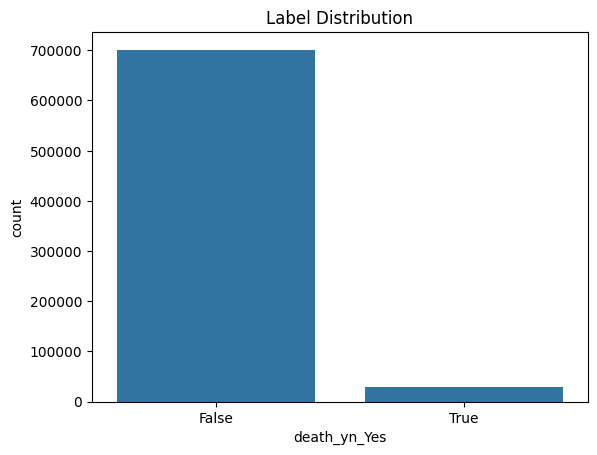

In [25]:
label_counts = df['death_yn_Yes'].value_counts()
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)

sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

In [26]:
#Proportion of each feature that is null.
df.isnull().sum()

current_status_Laboratory-confirmed case                                        0
current_status_Probable Case                                                    0
sex_Female                                                                      0
sex_Male                                                                        0
sex_Other                                                                       0
age_group_0 - 9 Years                                                           0
age_group_10 - 19 Years                                                         0
age_group_20 - 29 Years                                                         0
age_group_30 - 39 Years                                                         0
age_group_40 - 49 Years                                                         0
age_group_50 - 59 Years                                                         0
age_group_60 - 69 Years                                                         0
age_group_70 - 7

In [27]:
df.shape

(730187, 24)

In [28]:
features = df.drop('death_yn_Yes', axis = 1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [29]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X,y,test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

In [30]:
#Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [31]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.9666662101644777
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     70220
         1.0       0.59      0.43      0.50      2799

    accuracy                           0.97     73019
   macro avg       0.78      0.71      0.74     73019
weighted avg       0.96      0.97      0.96     73019

Testing Accuracy: 0.9676796450238979
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     70220
         1.0       0.04      0.03      0.04      2799

    accuracy                           0.94     73019
   macro avg       0.50      0.50      0.50     73019
weighted avg       0.93      0.94      0.93     73019



In [32]:
# Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

In [33]:
#Function to plot ROC Curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

#Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_score, title):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    plt.figure()
    plt.step(recall, precision, where='post', label='Precision-Recall curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

#Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

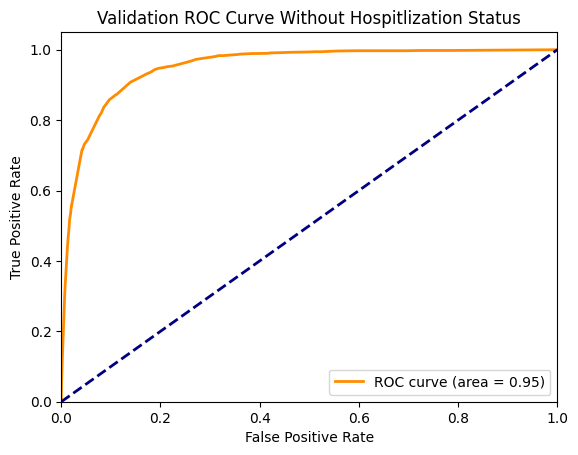

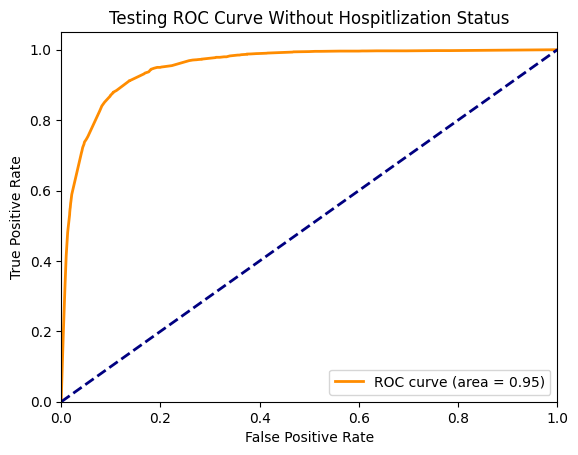

In [34]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitlization Status")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitlization Status")

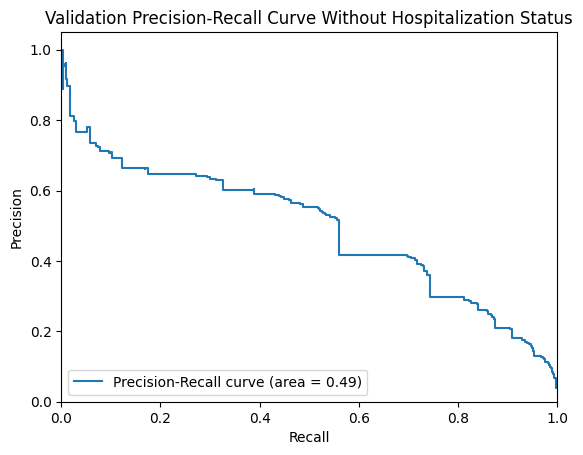

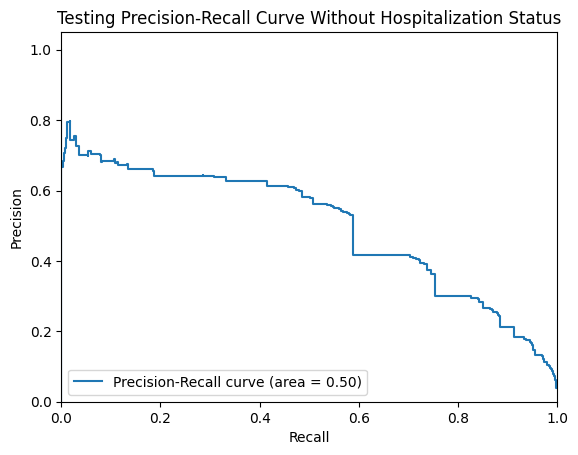

In [35]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve Without Hospitalization Status")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve Without Hospitalization Status")

Validation


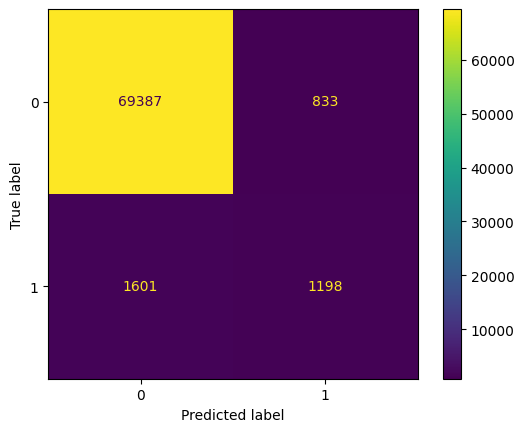

Testing


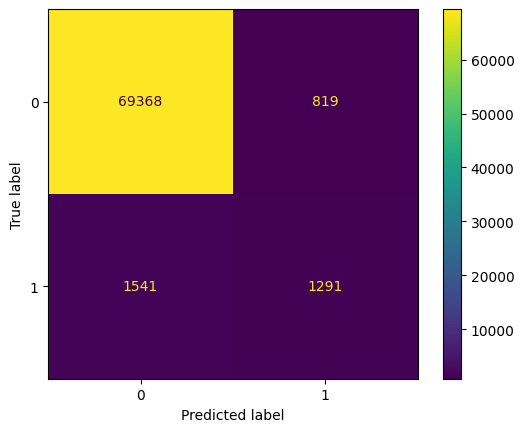

In [36]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [37]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'icu_yn_Yes', 'medcond_yn_Yes']

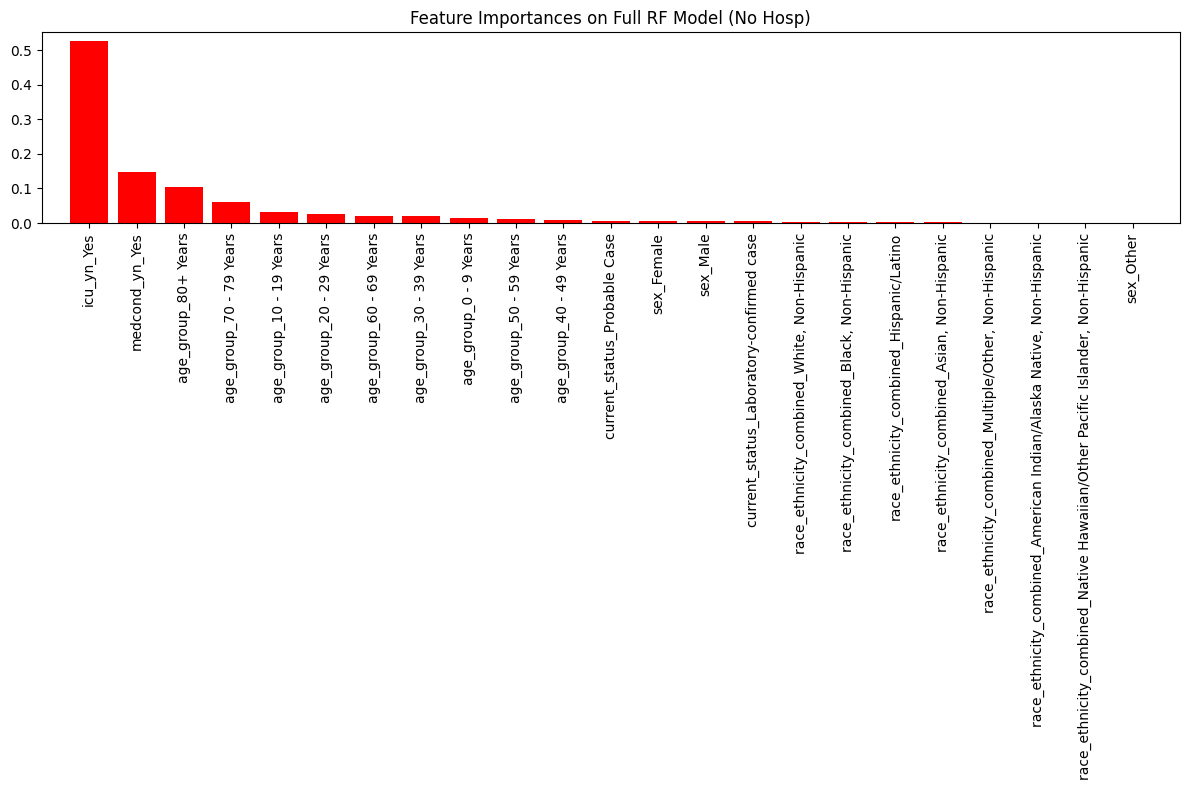

In [38]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No Hosp)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [39]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 138.301 seconds


<ipython-input-40-a22c13a3baad>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


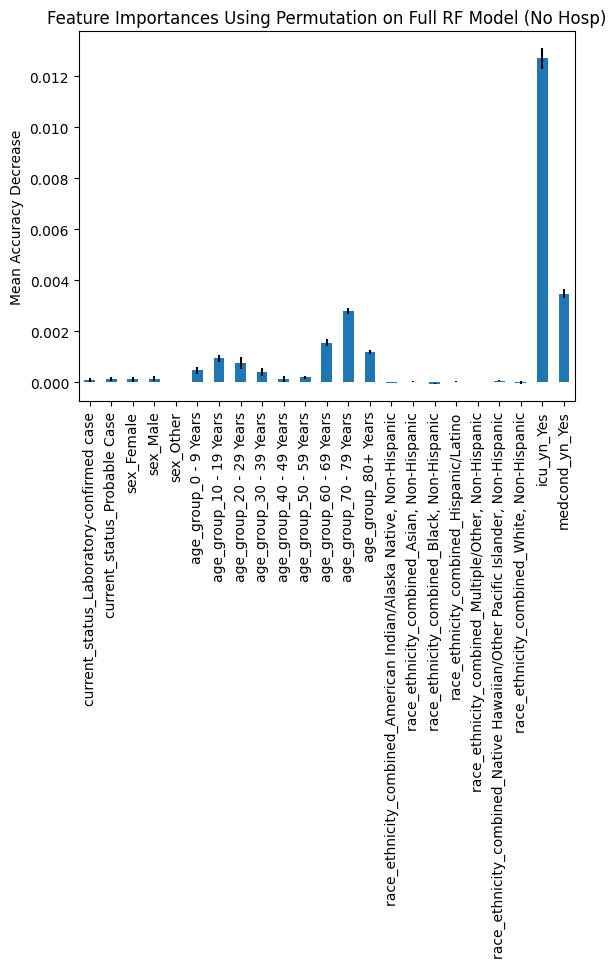

In [40]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No Hosp)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [41]:
explainer = shap.TreeExplainer(rf_classifier)
X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 23, 2)
X_train shape: (584149, 23)


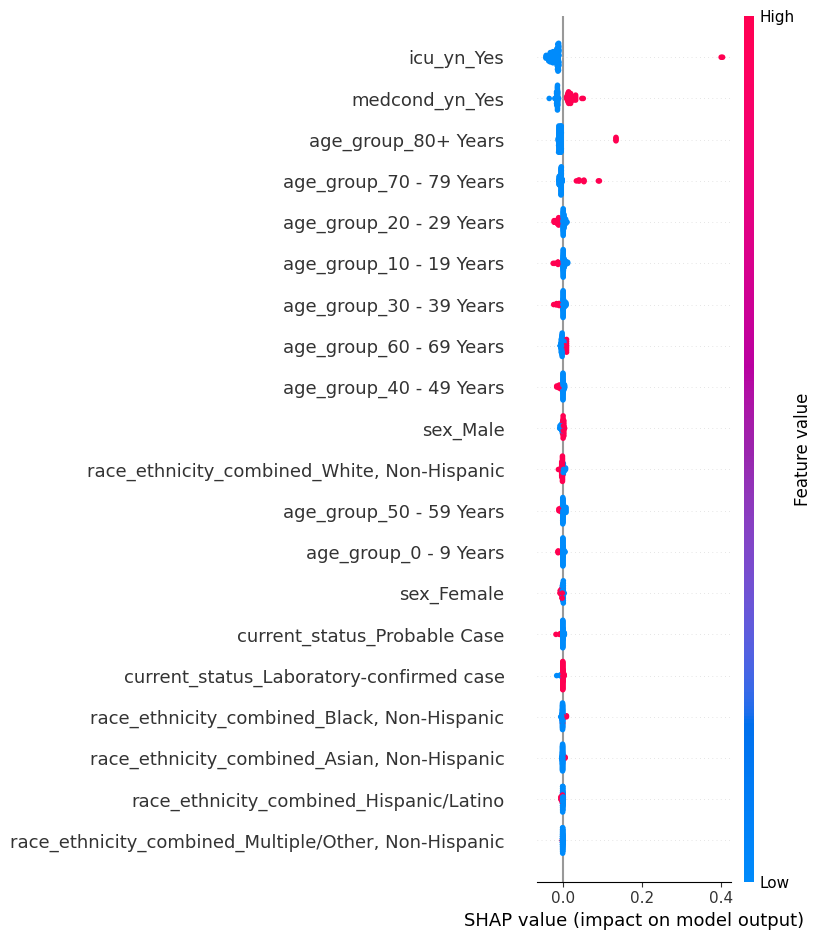

In [42]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### 2. Drop 'icu_yn_yes'

In [43]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [44]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [45]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [46]:
# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

# Fit the model on training data
rf_classifier.fit(X_train, y_train)

# Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

# Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [47]:
# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.9619551075747408
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.59      0.02      0.05      2799

    accuracy                           0.96     73019
   macro avg       0.78      0.51      0.51     73019
weighted avg       0.95      0.96      0.94     73019

Testing Accuracy: 0.9614483901450307
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.03      0.00      0.00      2799

    accuracy                           0.96     73019
   macro avg       0.49      0.50      0.49     73019
weighted avg       0.93      0.96      0.94     73019



In [48]:
# Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

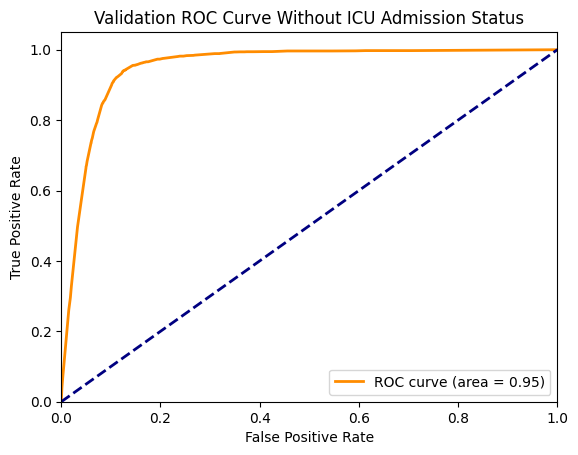

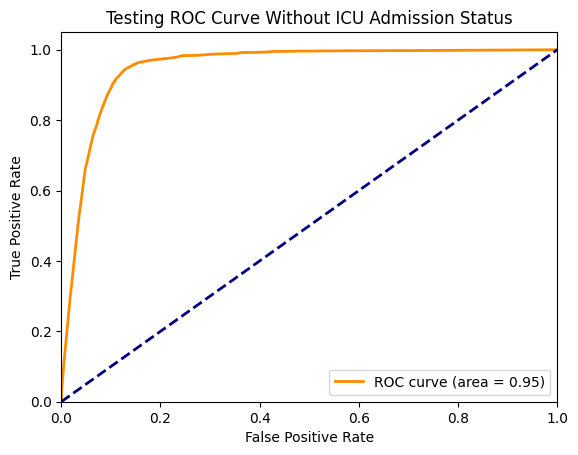

In [49]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without ICU Admission Status")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without ICU Admission Status")

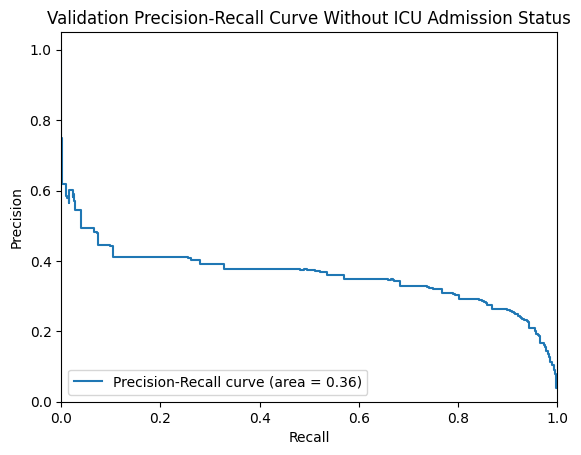

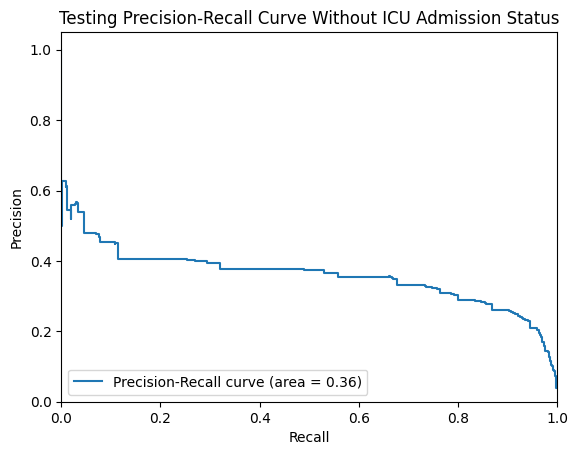

In [50]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve Without ICU Admission Status")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve Without ICU Admission Status")

Validation


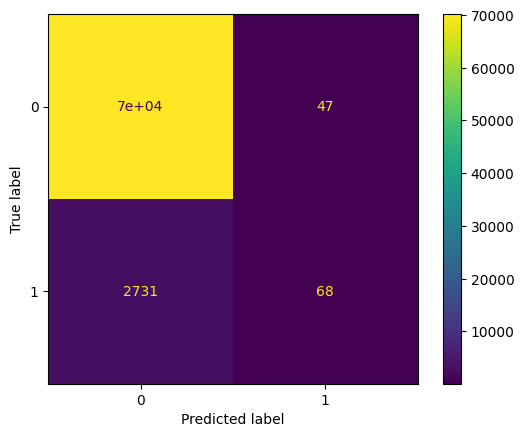

Testing


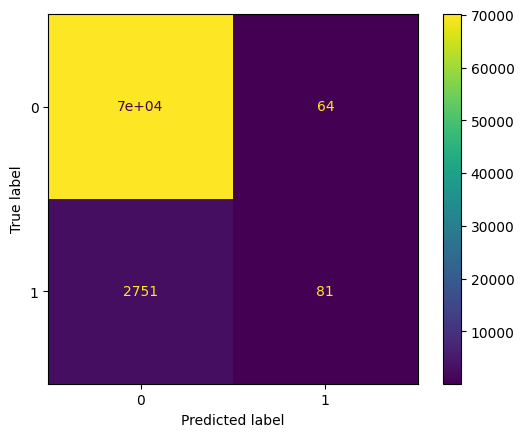

In [51]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [52]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'medcond_yn_Yes']

We see that with no ICU admission status,hospitalization status followed by pre-existing medical condtions and being 80+ are driving features.

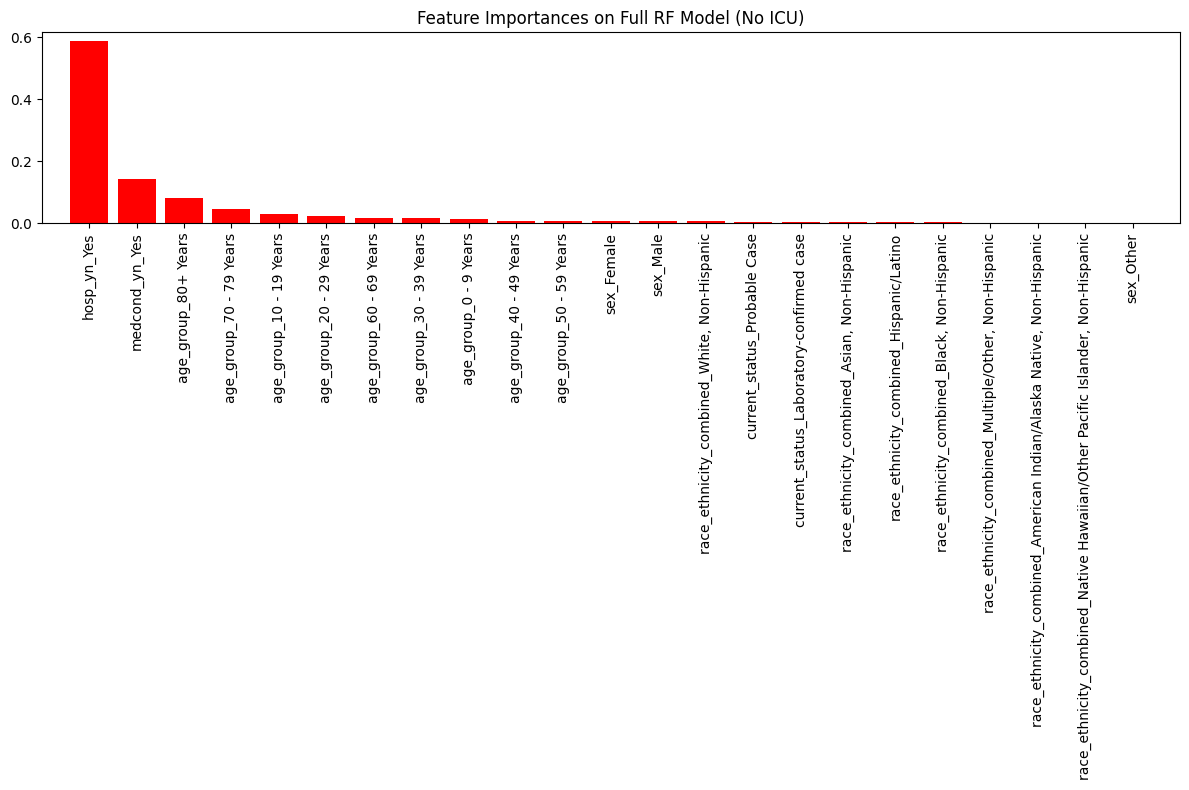

In [53]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No ICU)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [54]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 131.764 seconds


Interestingly enough, we see being a White-Non Hispanic is a very important feature.

<ipython-input-55-7ae1a2261f7e>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


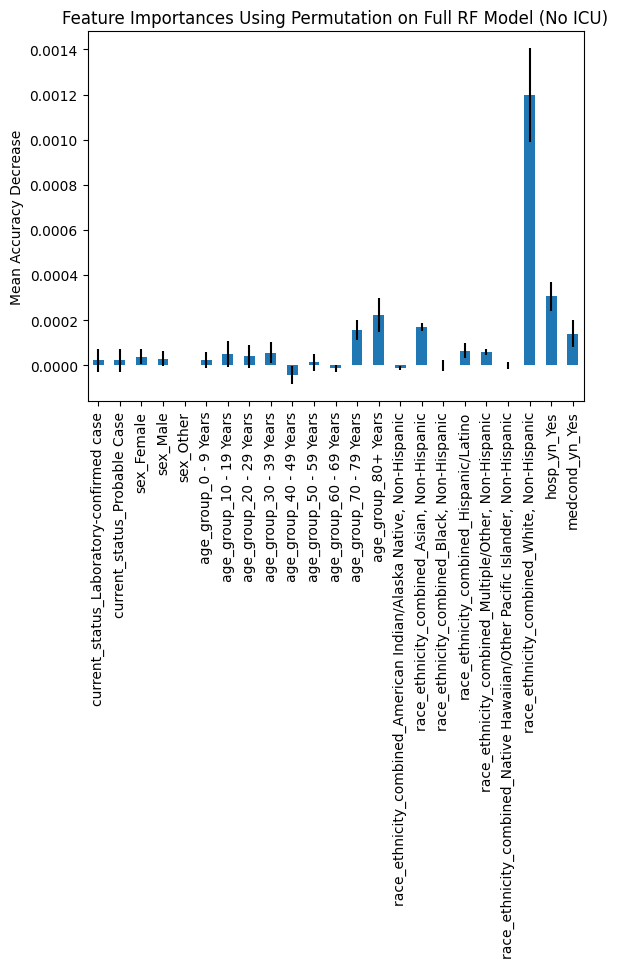

In [55]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No ICU)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [56]:
explainer = shap.TreeExplainer(rf_classifier)

X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 23, 2)
X_train shape: (584149, 23)


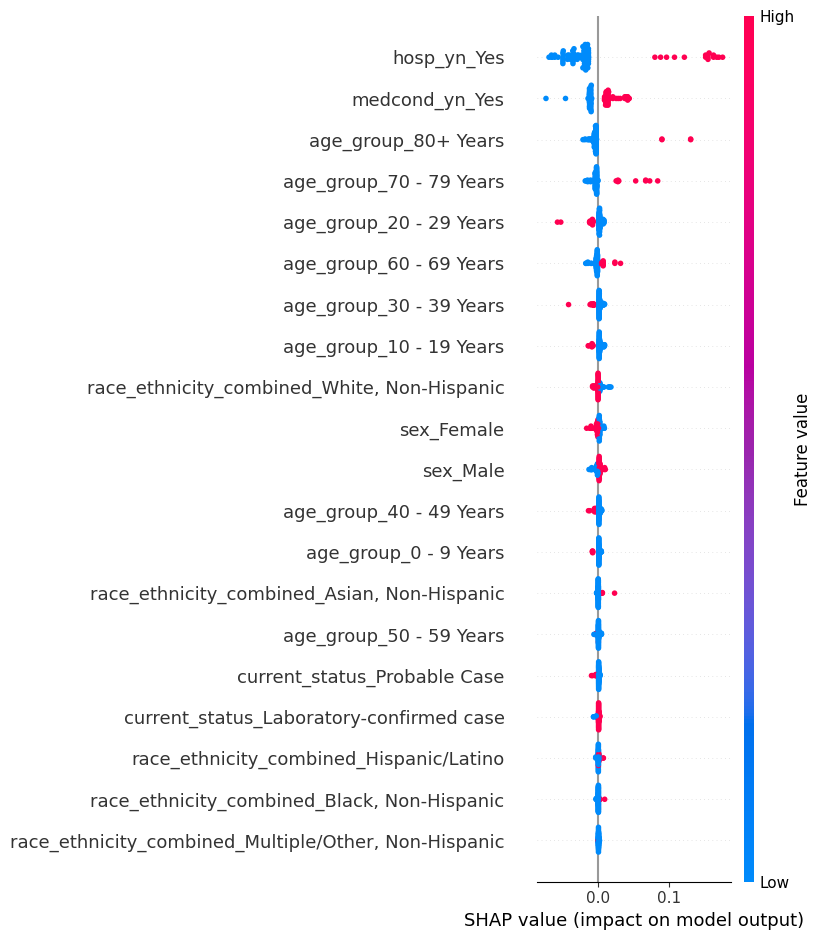

In [57]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### 3. Drop both 'icu_yn_Yes' and 'hosp_yn_Yes'

In [58]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [59]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [60]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [61]:
#Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [62]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.961763376655391
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.56      0.01      0.02      2799

    accuracy                           0.96     73019
   macro avg       0.76      0.51      0.50     73019
weighted avg       0.95      0.96      0.94     73019

Testing Accuracy: 0.9612703542913488
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.02      0.00      0.00      2799

    accuracy                           0.96     73019
   macro avg       0.49      0.50      0.49     73019
weighted avg       0.93      0.96      0.94     73019



In [63]:
#Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

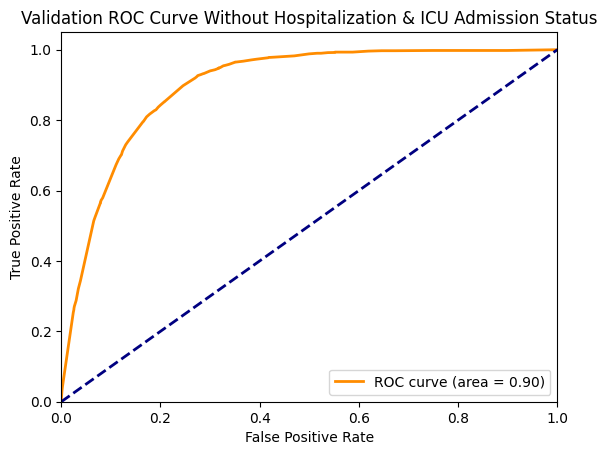

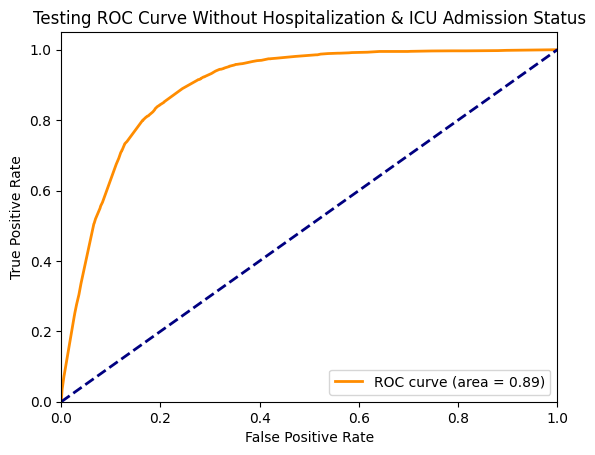

In [64]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitalization & ICU Admission Status")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitalization & ICU Admission Status")

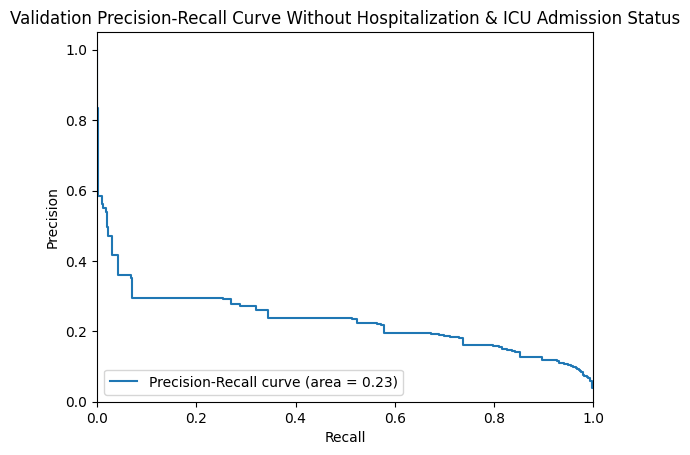

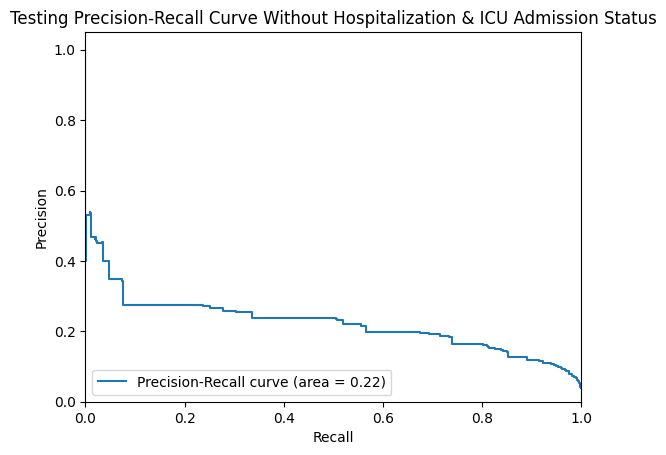

In [65]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve Without Hospitalization & ICU Admission Status")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve Without Hospitalization & ICU Admission Status")

Validation


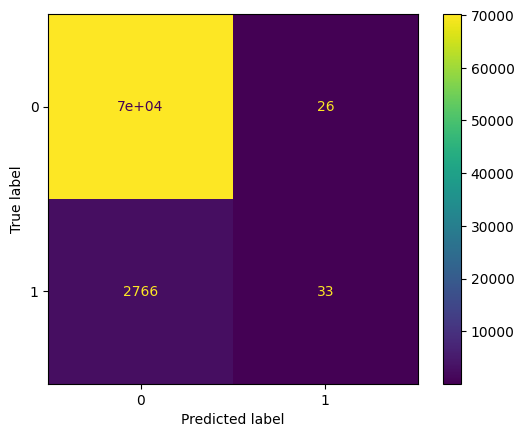

Testing


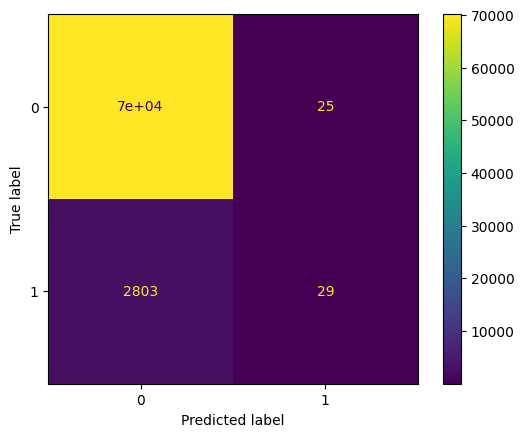

In [66]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [67]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'medcond_yn_Yes']

With no ICU or hospitalization status, we see pre-existing medical conditions and old age play a major role in determining mortality.

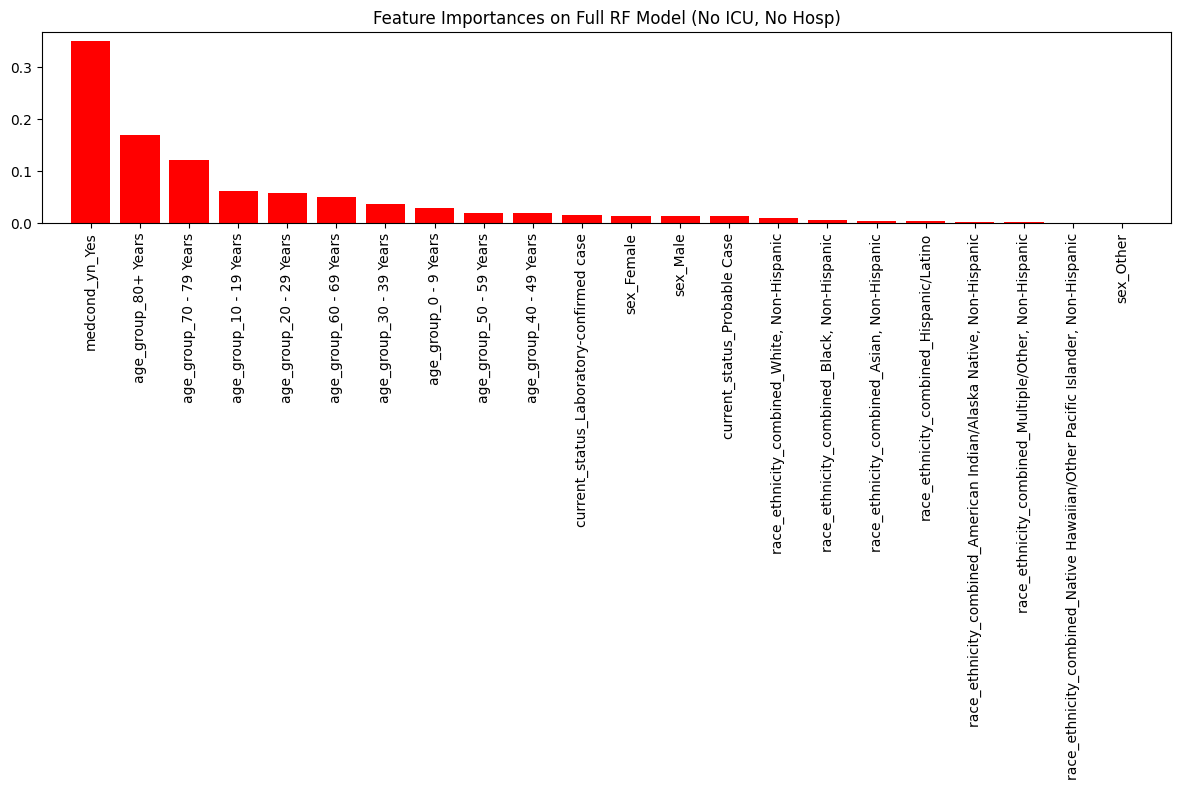

In [68]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No ICU, No Hosp)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [69]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 116.289 seconds


<ipython-input-70-357e762ed8c3>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


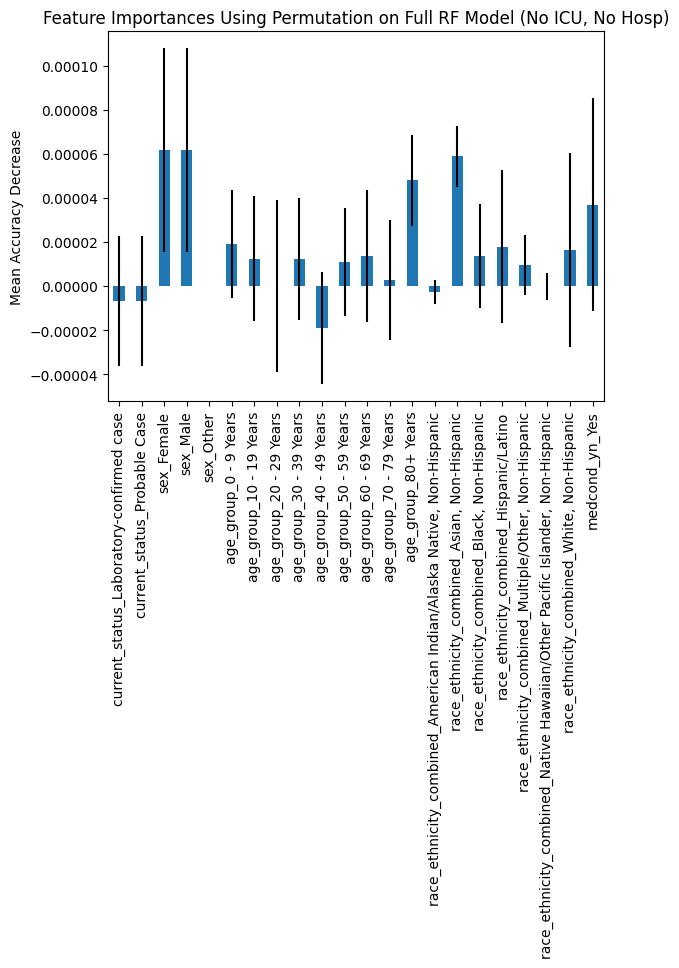

In [70]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No ICU, No Hosp)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Lot of variety in feature importance based on permutation.

In [71]:
explainer = shap.TreeExplainer(rf_classifier)

X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 22, 2)
X_train shape: (584149, 22)


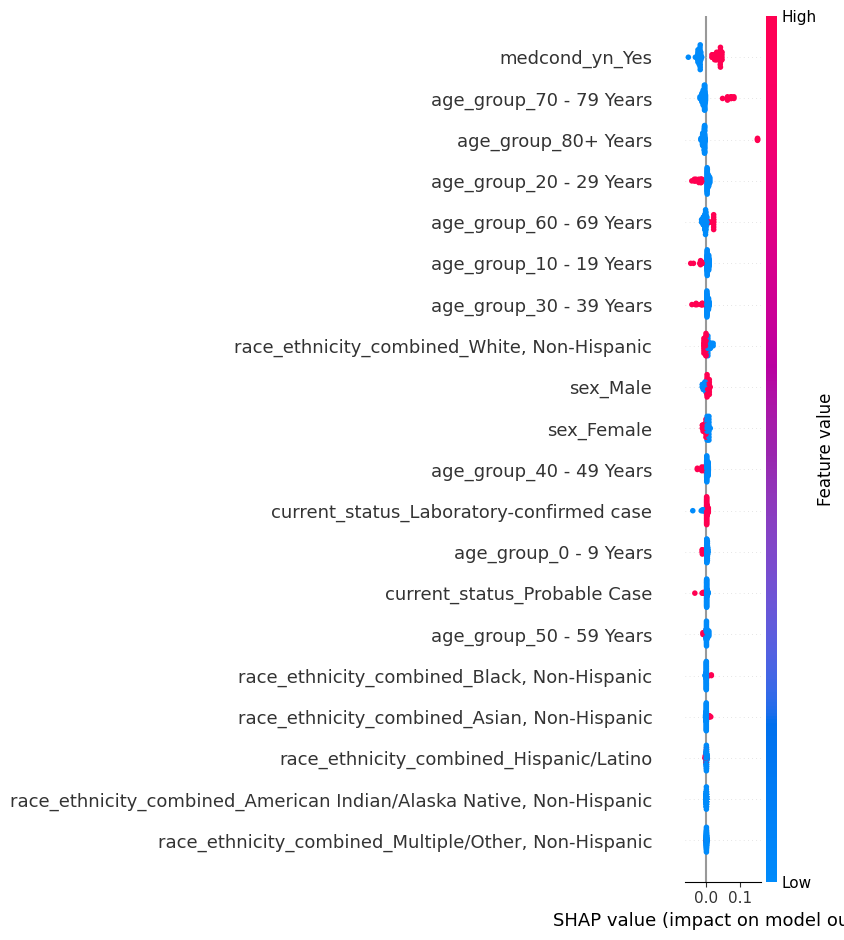

In [72]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### 4. Fixing data imbalance

Since we see that the data imbalance impacts precison and recall in predicting death cases, we will make sure death and non-death cases are equal.

In [73]:
#Majority class
false_data = df[df['death_yn_Yes'] == 0]
#Minority class
true_data = df[df['death_yn_Yes'] == 1]

undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [74]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [75]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [76]:
#Initialize the RF model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [77]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.8179923584577978
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      2880
         1.0       0.78      0.89      0.83      2878

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.82      0.82      0.82      5758

Testing Accuracy: 0.8176450156304272
              precision    recall  f1-score   support

         0.0       0.50      0.43      0.46      2880
         1.0       0.50      0.57      0.53      2878

    accuracy                           0.50      5758
   macro avg       0.50      0.50      0.50      5758
weighted avg       0.50      0.50      0.50      5758



In [78]:
#Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

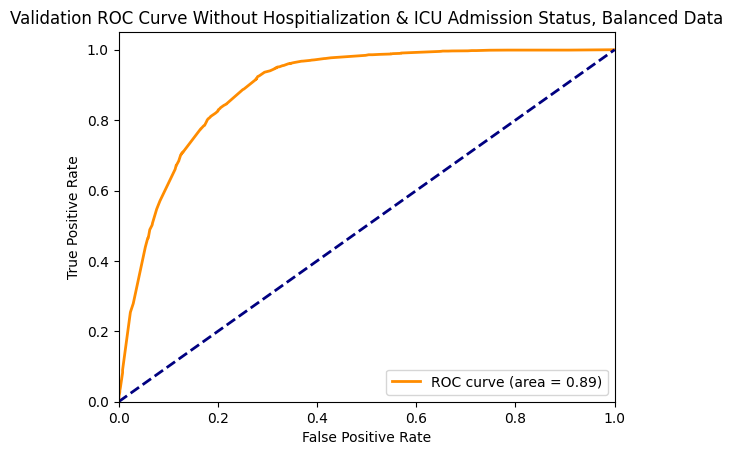

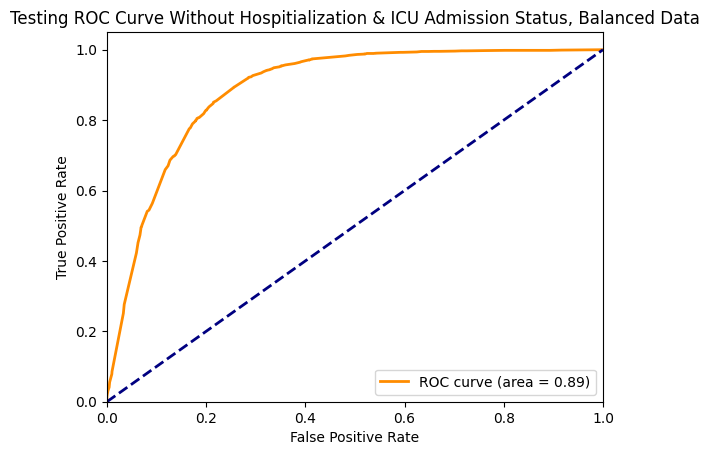

In [79]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data")

A BIG improvement in PR curves and PR-AUC with balanced data

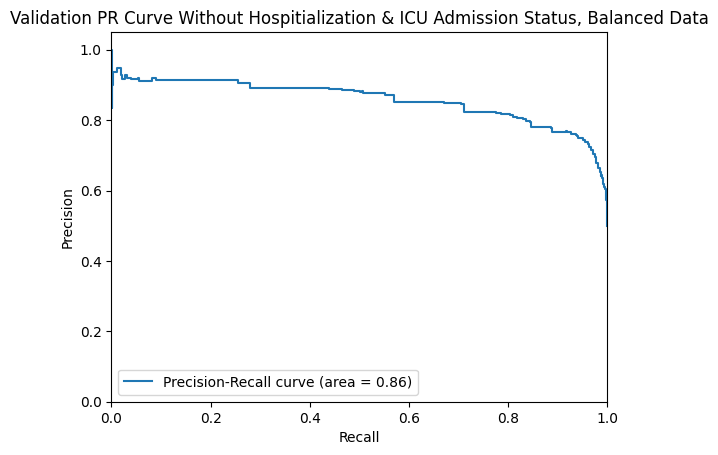

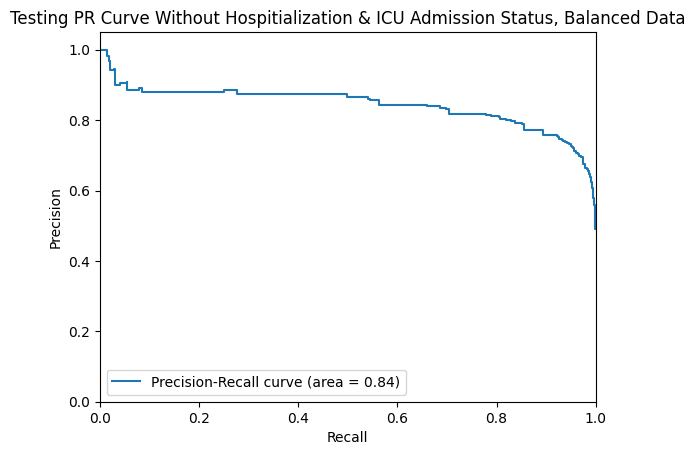

In [80]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation PR Curve Without Hospitialization & ICU Admission Status, Balanced Data")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing PR Curve Without Hospitialization & ICU Admission Status, Balanced Data")

Low amount of false negatives and positives now

Validation


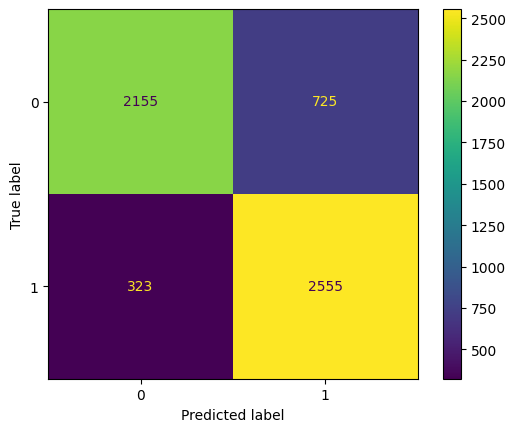

Testing


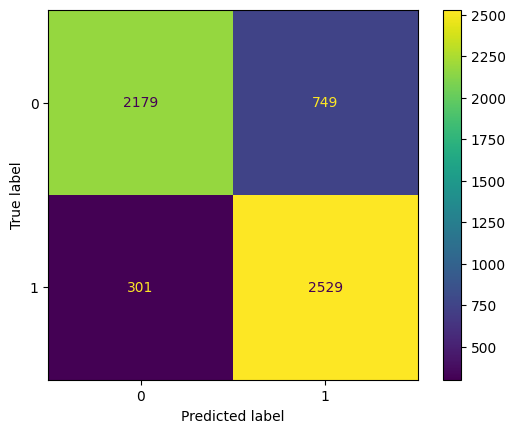

In [81]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [82]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'medcond_yn_Yes']

Medical conditions and old age once again driving features

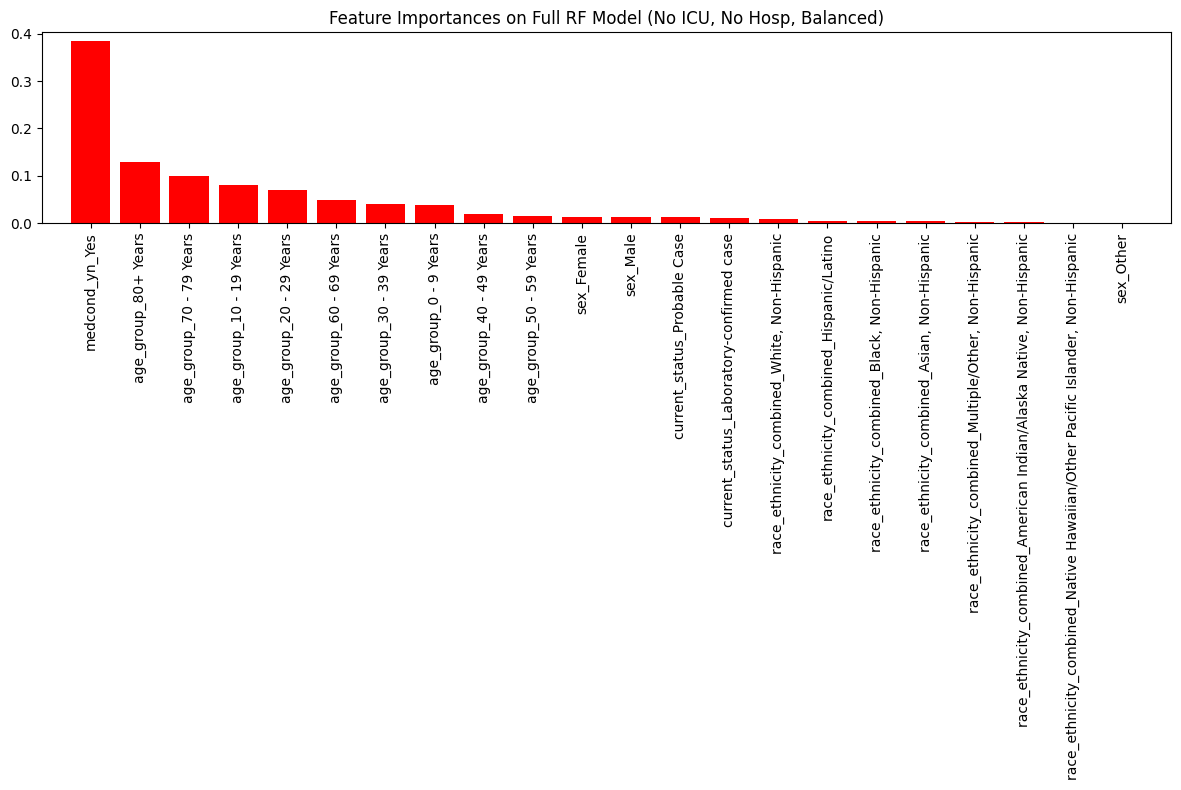

In [83]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No ICU, No Hosp, Balanced)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [84]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 11.983 seconds


<ipython-input-85-e124643c0882>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


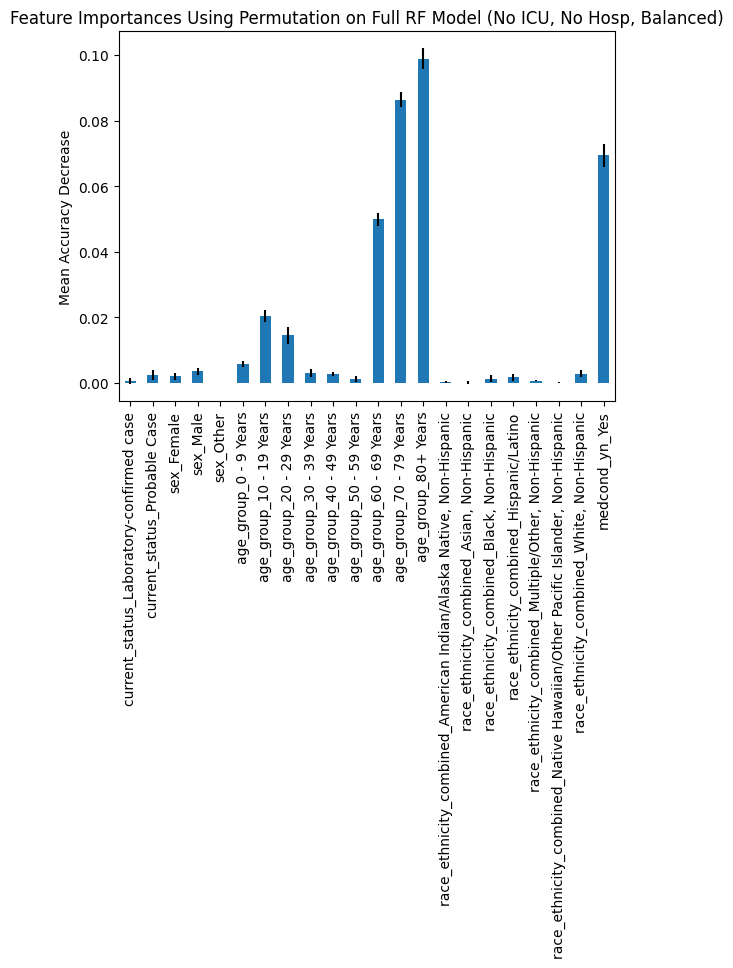

In [85]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No ICU, No Hosp, Balanced)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Old age seem to me more important features than medical conditions

In [86]:
explainer = shap.TreeExplainer(rf_classifier)

X_sample = shap.sample(X_train, 10000)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (10000, 22, 2)
X_train shape: (46056, 22)


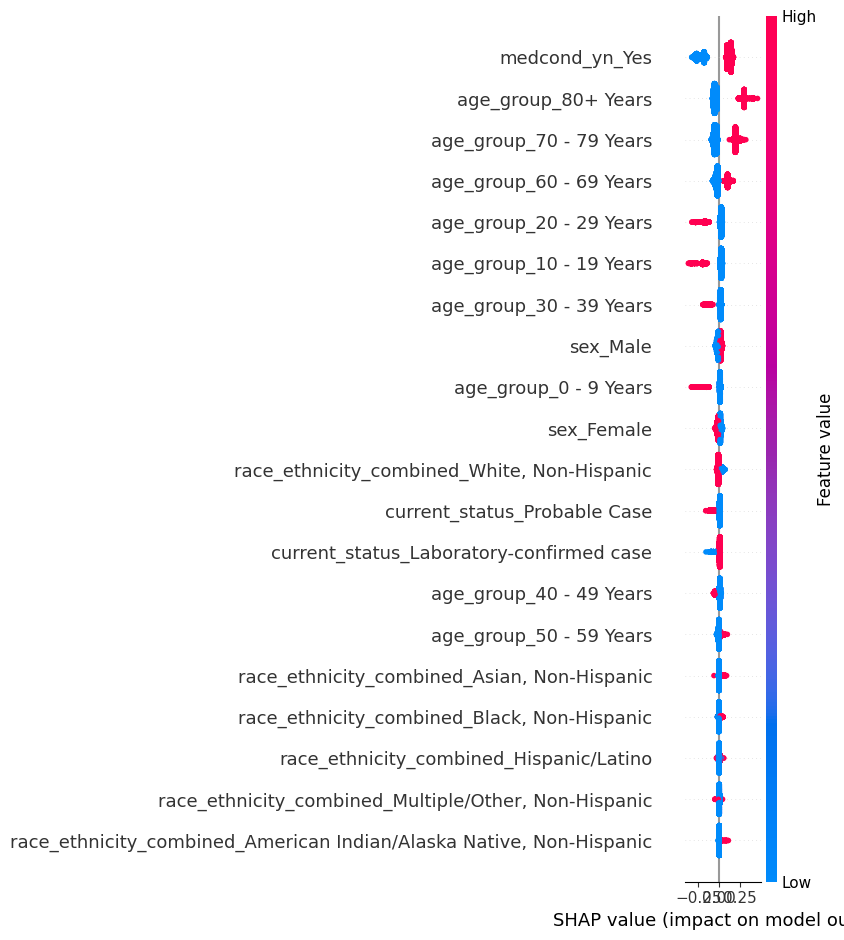

In [87]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### Model Tuning

Now that we have an improved model and balanced dataset, we will play around with hyperparamters to determine the best RF model.

In [89]:
#Define hyperparameters and their respective ranges to consider for the random search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']}

#Initialize the base model
rf_classifier = RandomForestClassifier(random_state=42)

#Initialize RandomizedSearchCV with the desired number of iterations and cross-validation folds
random_search_1 = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, n_iter=100, cv=StratifiedKFold(5),
    verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')
random_search_2 = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, n_iter=100, cv=StratifiedKFold(5),
    verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')

#Perform the RandomizedSearchCV to find the best model
best_rf_1 = random_search_1.fit(X_train, y_train)
best_rf_2 = random_search_2.fit(X_train, y_train)

#Best hyperparameters from RandomizedSearchCV
print("Best hyperparameters for RF (Acc):\n", best_rf_1.best_params_)
print("Best hyperparameters for RF (F-1):\n", best_rf_2.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters for RF (Acc):
 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 40, 'criterion': 'log_loss', 'class_weight': 'balanced', 'bootstrap': False}
Best hyperparameters for RF (F-1):
 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 40, 'criterion': 'log_loss', 'class_weight': 'balanced', 'bootstrap': False}


Better classification report, with better PR numbers in both testing and validation.

In [102]:
#Evaluate the best model on the validation set
best_rf_model_1 = best_rf_1.best_estimator_
y_pred_val_1 = best_rf_model_1.predict(X_val)
y_pred_test_1 = best_rf_model_1.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_1))
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_1))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test_1))

Validation Accuracy: 0.8183397012851684
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81      2880
         1.0       0.78      0.89      0.83      2878

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.82      0.82      0.82      5758

Testing Accuracy: 0.8172976728030567
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.81      2928
         1.0       0.77      0.89      0.83      2830

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.83      0.82      0.82      5758



In [90]:
#Evaluate the best model on the validation set
best_rf_model = best_rf_2.best_estimator_
y_pred_val = best_rf_model.predict(X_val)
y_pred_test = best_rf_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

Validation Accuracy: 0.8183397012851684
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81      2880
         1.0       0.78      0.89      0.83      2878

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.82      0.82      0.82      5758

Testing Accuracy: 0.8172976728030567
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.81      2928
         1.0       0.77      0.89      0.83      2830

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.83      0.82      0.82      5758



In [91]:
#Predict probabilities for the test and val set
y_scores_val = best_rf_model.predict_proba(X_val)[:, 1]
y_scores_test = best_rf_model.predict_proba(X_test)[:, 1]

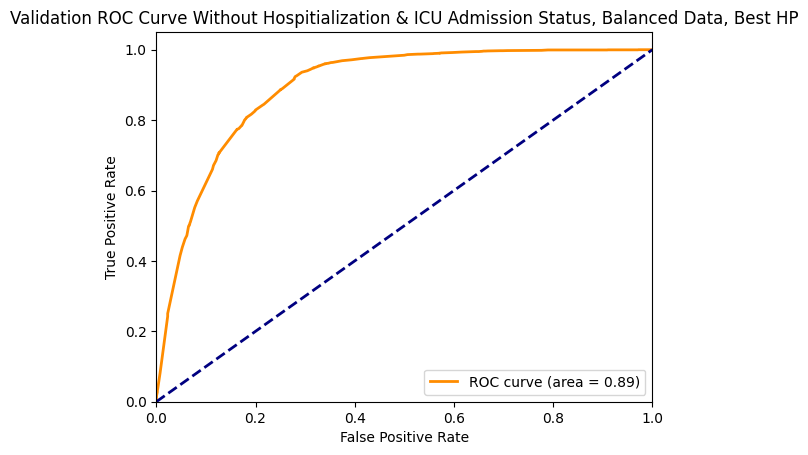

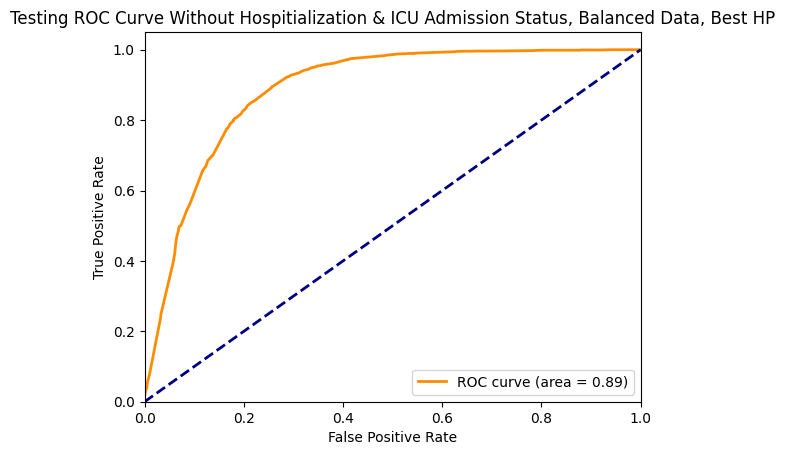

In [92]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

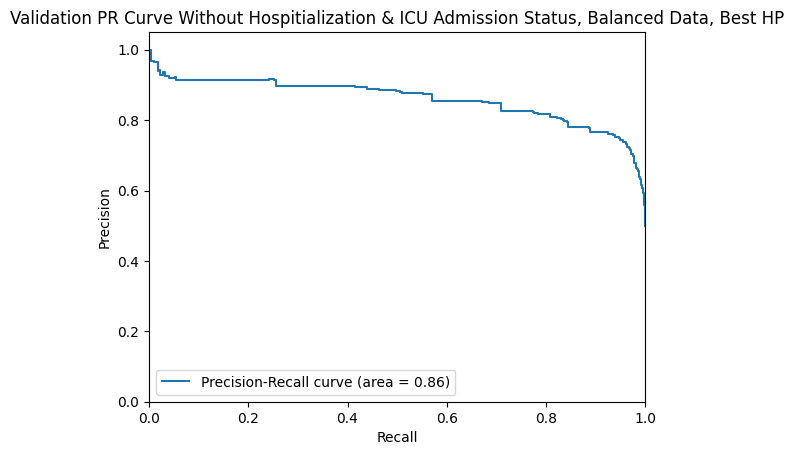

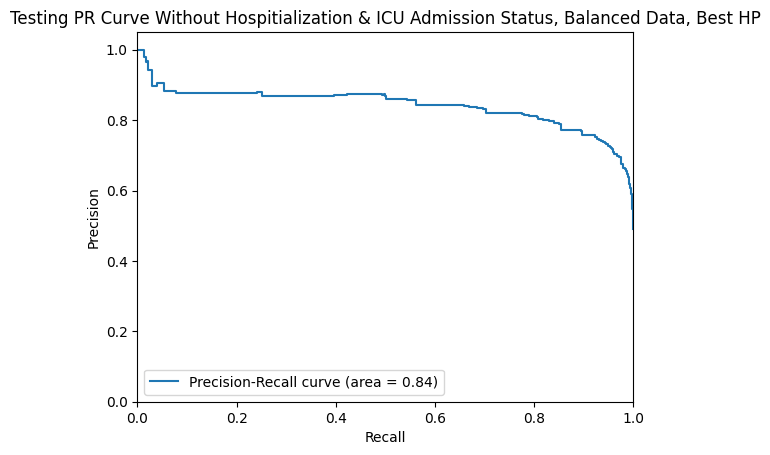

In [93]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation PR Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing PR Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

Validation


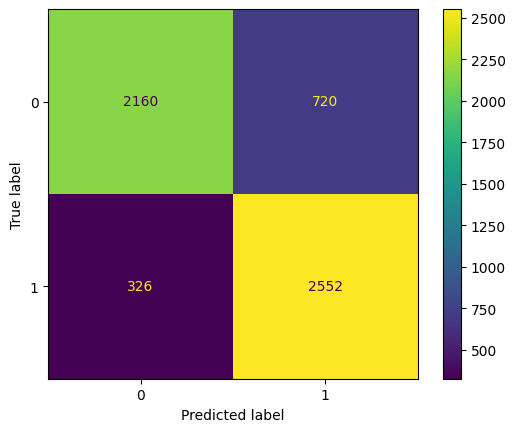

Testing


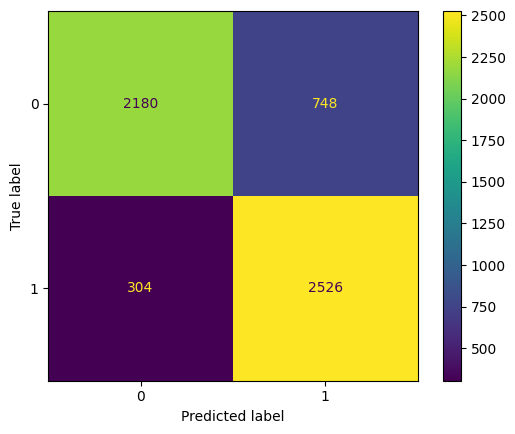

In [94]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

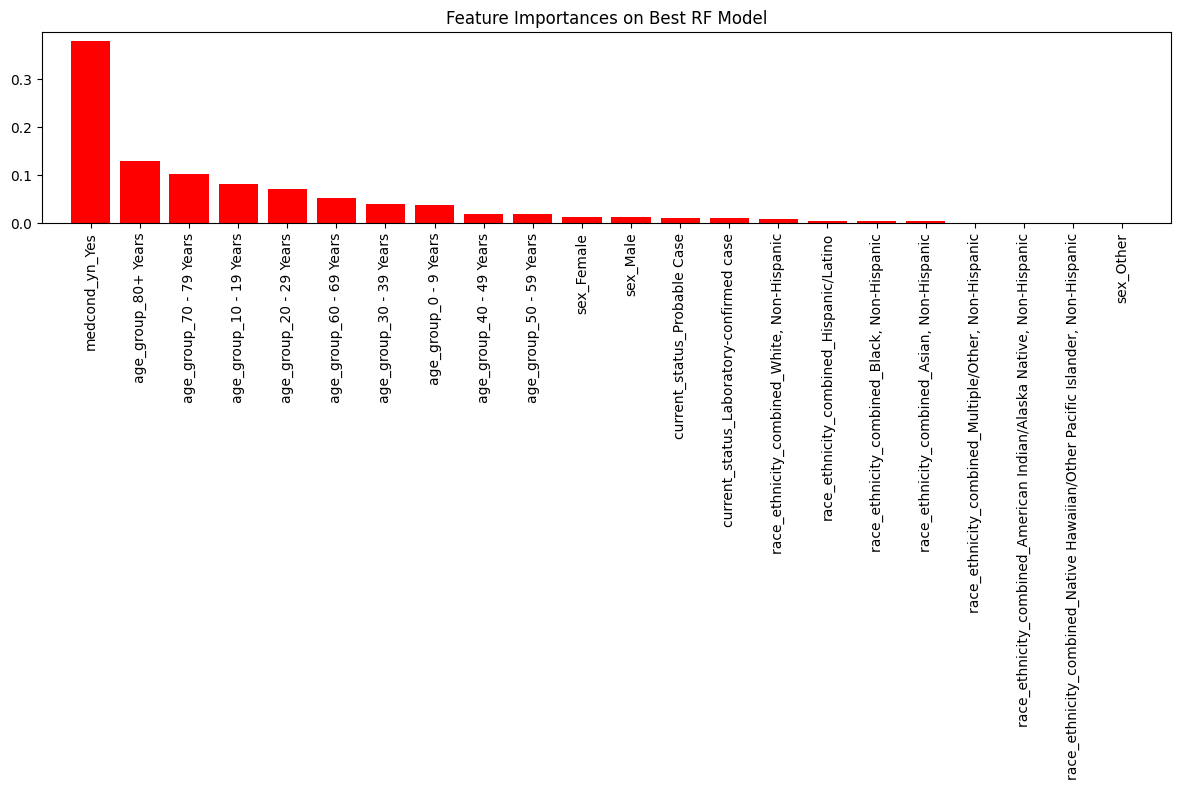

In [95]:
#Feature Importance Plot
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Best RF Model")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [96]:
start_time = time.time()
result = permutation_importance(
    best_rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 11.368 seconds


<ipython-input-97-36e0b373a1f7>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


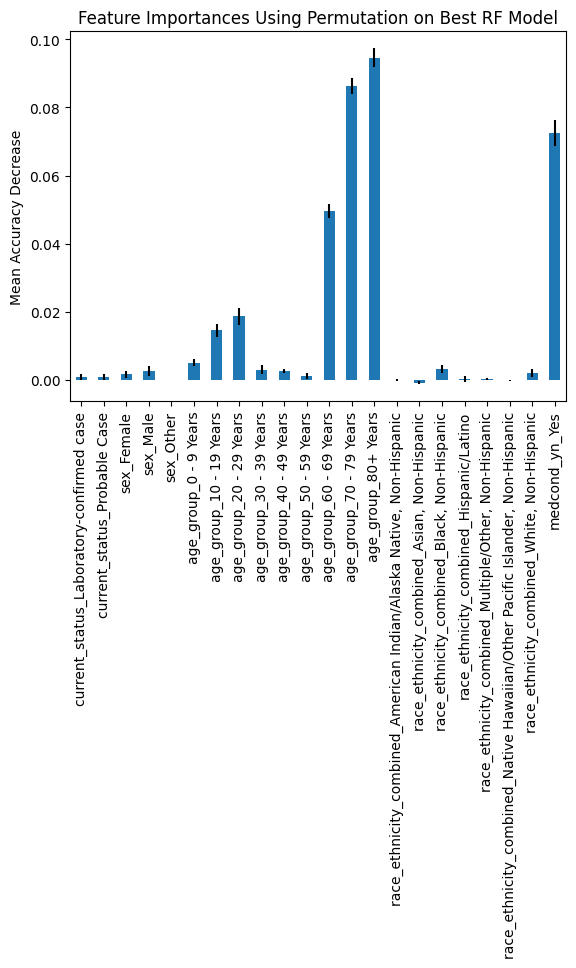

In [97]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Best RF Model")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [98]:
explainer = shap.TreeExplainer(best_rf_model)

X_sample = shap.sample(X_train, 10000)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (10000, 22, 2)
X_train shape: (46056, 22)


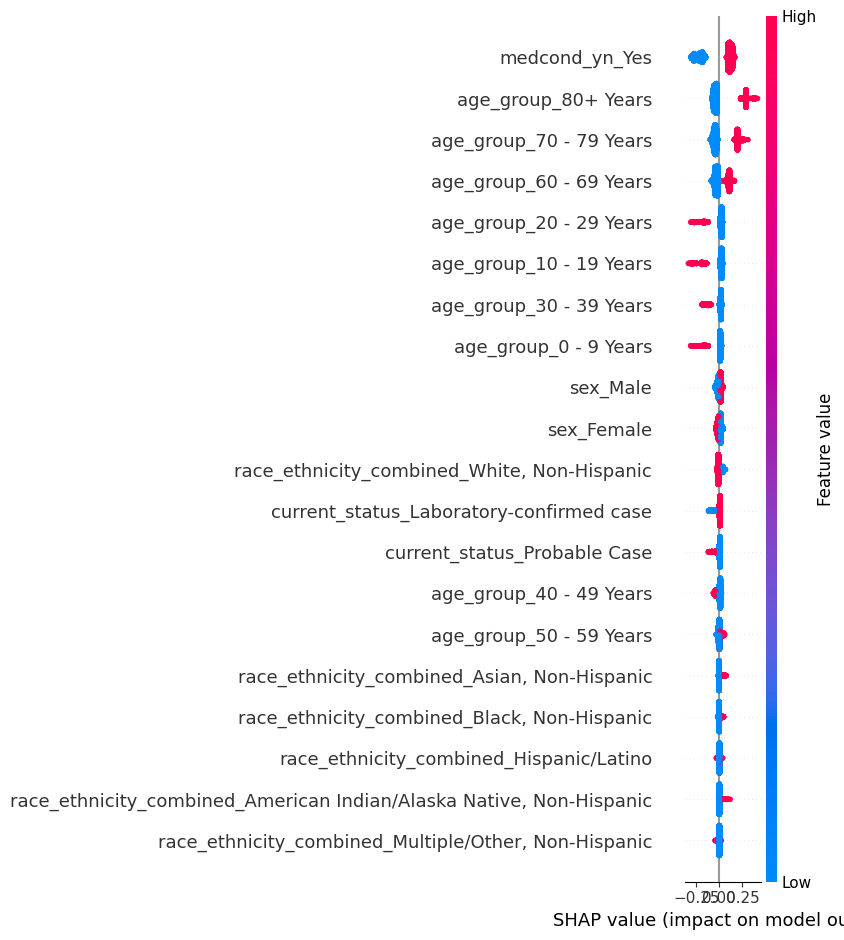

In [99]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

Death


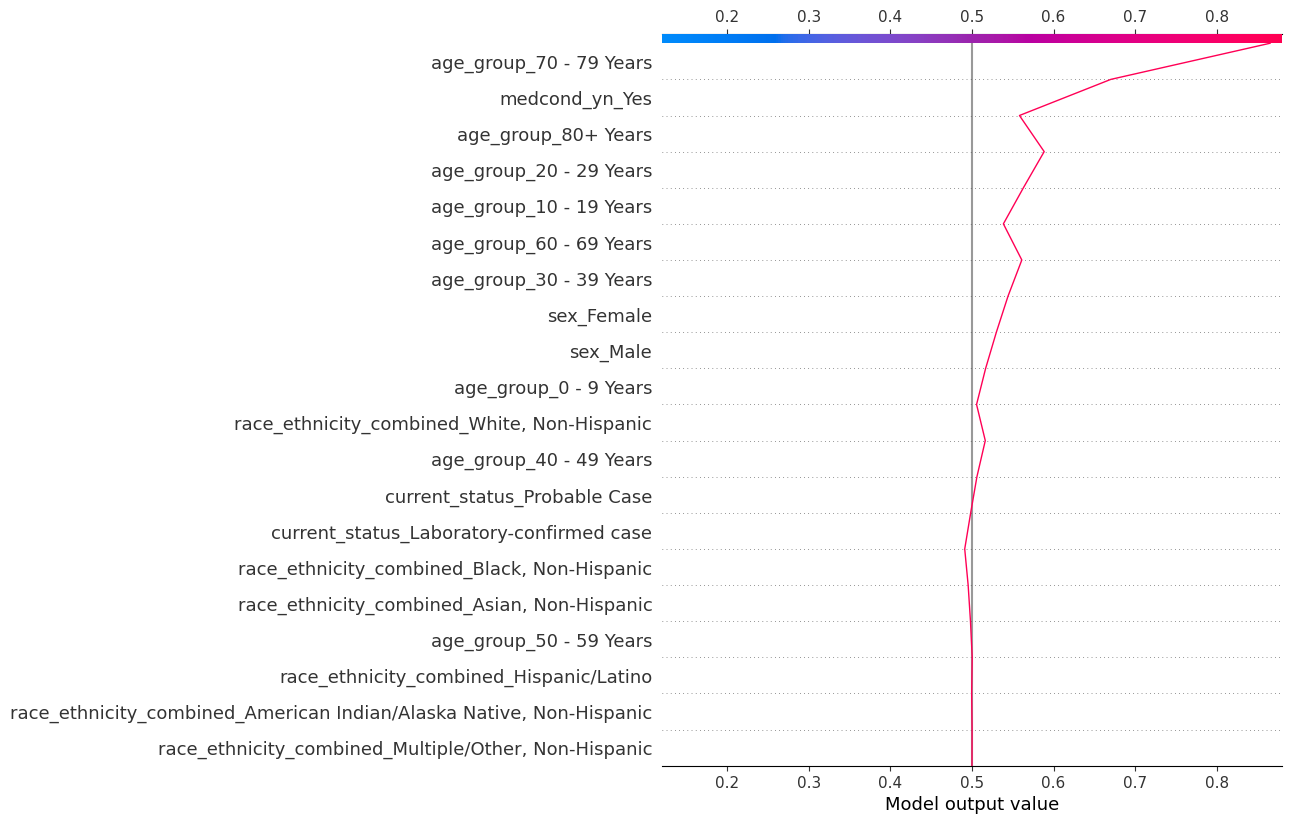

In [100]:
print("Death")
shap.decision_plot(explainer.expected_value[0], shap_values_positive_class[0], feature_names=feature_names)

Non-Death


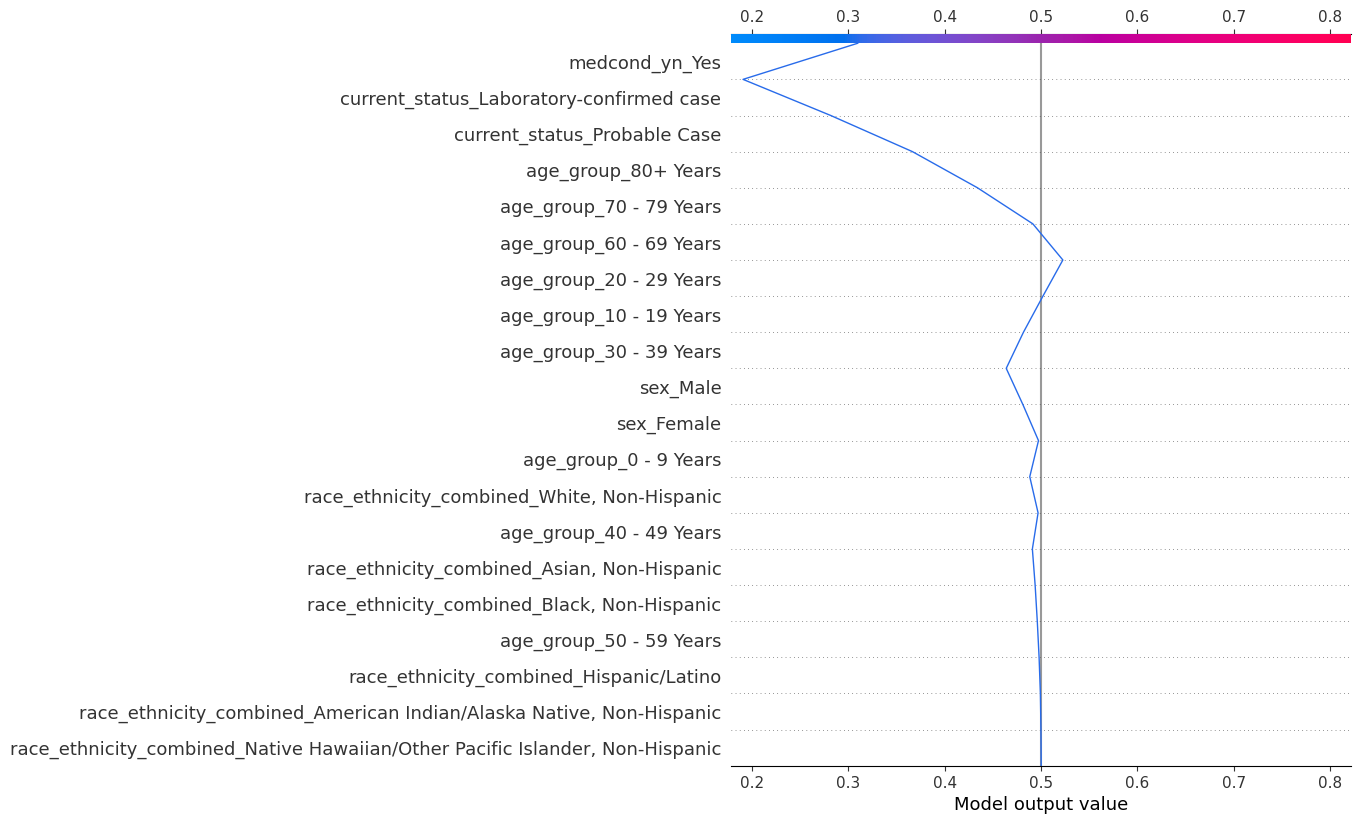

In [101]:
print("Non-Death")
shap.decision_plot(explainer.expected_value[1], shap_values_positive_class[1], feature_names)

### Recursive Feature Elimination with Cross Validation (RFECV)

Explore/see best features for RF

In [103]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")

columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']

df_encoded = one_hot_encoding_features(df, columns_to_encode)
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [104]:
#Majority class
false_data = df[df['death_yn_Yes'] == 0]
#Minority class
true_data = df[df['death_yn_Yes'] == 1]

undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [105]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [107]:
#Since the features were converted to tensors and then to numpy,we assume they do not have the column names anymore.
#Make sure to have a list of your original feature names.
feature_names = list(df.drop('death_yn_Yes', axis=1).columns)

#Initialize the classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

#Create RFECV models
rf_rfecv_1 = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rf_rfecv_2 = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='f1_weighted')

#Fit RFECVs
rf_rfecv_1.fit(X_train, y_train)
rf_rfecv_2.fit(X_train, y_train)


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=42), scoring='f1_weighted')

In [108]:
#Get the features that contribute the most to the prediction
rf_best_features_1 = [feature_names[i] for i in range(len(feature_names)) if rf_rfecv_1.support_[i]]
rf_best_features_2 = [feature_names[i] for i in range(len(feature_names)) if rf_rfecv_2.support_[i]]

print(f"Random Forest Selected Features (Acc): {rf_best_features_1}")
print(f"Random Forest Selected Features (F-1): {rf_best_features_2}")


Random Forest Selected Features (Acc): ['sex_Female', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years', 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years', 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']
Random Forest Selected Features (F-1): ['sex_Female', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years', 'age_group_30 - 39 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years', 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']


Try finding best HP for these features

In [109]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'sex_Male', 'sex_Other', 'current_status_Laboratory-confirmed case',
'current_status_Probable Case','race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic', 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'race_ethnicity_combined_Multiple/Other, Non-Hispanic' ]
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [110]:
#Majority class
false_data = df[df['death_yn_Yes'] == 0]
#Minority class
true_data = df[df['death_yn_Yes'] == 1]

undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [111]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [ ]:
#Define hyperparameters and their respective ranges to consider for the random search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']}

#Initialize the base model
rf_classifier = RandomForestClassifier(random_state=42)

#Initialize RandomizedSearchCV with the desired number of iterations and cross-validation folds
random_search_1 = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, n_iter=100, cv=StratifiedKFold(5),
    verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')
random_search_2 = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, n_iter=100, cv=StratifiedKFold(5),
    verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')

#Perform the RandomizedSearchCV to find the best model
best_rf_1 = random_search_1.fit(X_train, y_train)
#best_rf_2 = random_search_2.fit(X_train, y_train)

#Best hyperparameters from RandomizedSearchCV
print("Best hyperparameters for RF (Acc):\n", best_rf_1.best_params_)
#print("Best hyperparameters for RF (F-1):\n", best_rf_2.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
#Evaluate the best model on the validation set
best_rf_model = best_rf_2.best_estimator_
y_pred_val = best_rf_model.predict(X_val)
y_pred_test = best_rf_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))